In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import keras
import cv2
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint
import pathlib
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, Adamax
from keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dense, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, GlobalMaxPool2D, add
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
import scipy
import tensorflow as tf
from skimage.transform import resize

2024-04-20 07:12:47.981473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 07:12:47.981575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 07:12:48.094538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [3]:
# def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
#     # first layer
#     x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
#                padding="same")(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     # second layer
#     x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
#                padding="same")(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     return x


# def get_unet(input_shape=(256,256,1), n_filters=16, dropout=0.5, batchnorm=True):
#     # contracting path
#     strategy=tf.distribute.MirroredStrategy()
#     with strategy.scope():
#         c1 = conv2d_block(input_img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm)
#         p1 = MaxPooling2D((2, 2))(c1)
#         p1 = Dropout(dropout * 0.5)(p1)

#         c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm)
#         p2 = MaxPooling2D((2, 2))(c2)
#         p2 = Dropout(dropout)(p2)

#         c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm)
#         p3 = MaxPooling2D((2, 2))(c3)
#         p3 = Dropout(dropout)(p3)

#         c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm)
#         p4 = MaxPooling2D(pool_size=(2, 2))(c4)
#         p4 = Dropout(dropout)(p4)

#         c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

#         # expansive path
#         u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
#         u6 = concatenate([u6, c4])
#         u6 = Dropout(dropout)(u6)
#         c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm)

#         u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
#         u7 = concatenate([u7, c3])
#         u7 = Dropout(dropout)(u7)
#         c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm)

#         u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
#         u8 = concatenate([u8, c2])
#         u8 = Dropout(dropout)(u8)
#         c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm)

#         u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
#         u9 = concatenate([u9, c1], axis=3)
#         u9 = Dropout(dropout)(u9)
#         c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm)

#         outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)
#         model = Model(inputs=[input_img], outputs=[outputs])
#         model.compile(optimizer=Adamax(learning_rate=1e-4), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
#     return model


In [4]:
def unet(input_size=(256, 256, 3)):
#     strategy=tf.distribute.MirroredStrategy()
#     with strategy.scope():
    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(Adamax(learning_rate= 1e-4), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
    return model

In [5]:
input_path = r"/kaggle/input/chiu-2015/2015_BOE_Chiu"
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 256
height = 256
width_out = 256
height_out = 256

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float32])

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        img_array = np.transpose(img_tensor, (2, 0, 1))/255
        img_array = resize(img_array, (img_array.shape[0] ,width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0, 1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array.shape[0], width_out, height_out))

        for idx in data_indexes:
#             img=np.transpose((np.expand_dims(img_array[idx], 0)), (1, 2, 0))
#             x += [img]
#             fluid=np.transpose(np.expand_dims(fluid_array[idx], 0), (1, 2, 0))
#             y += [fluid]
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 256, 256), (99, 1, 256, 256), (11, 1, 256, 256), (11, 1, 256, 256))

In [7]:
def transpose(img_array):
    x=[]
    for i,img in enumerate(img_array):
        x+=[np.transpose(img, (1, 2, 0))]
    return np.array(x)

In [8]:
x_train=transpose(x_train)
y_train=transpose(y_train)
x_val=transpose(x_val)
y_val=transpose(y_val)

In [9]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 256, 256, 1), (99, 256, 256, 1), (11, 256, 256, 1), (11, 256, 256, 1))

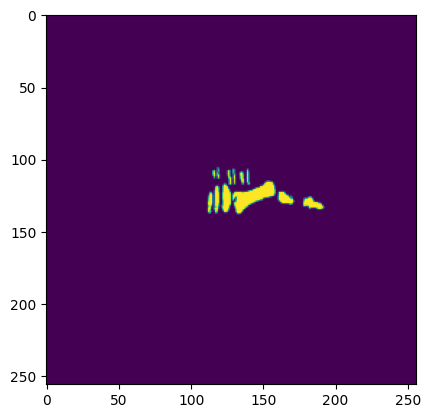

In [10]:
plt.imshow(y_train[2])

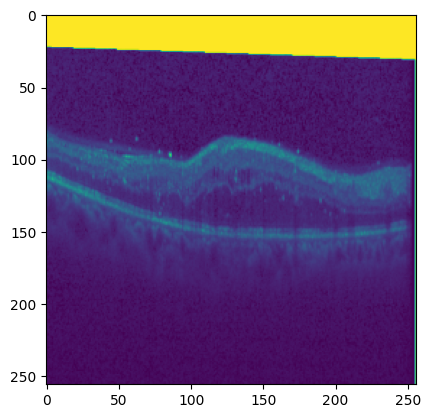

In [11]:
plt.imshow(x_train[2])

In [12]:
# input_img = Input((512, 512, 1), name='img')
# model = get_unet(input_img, n_filters=16, dropout=0.25, batchnorm=True)
# model.summary()

model = unet((256, 256, 1))
callbacks = [
    CSVLogger(filename="BatchNorm.csv",separator=',',append=False),
    ModelCheckpoint("Model.keras", monitor='val_dice_loss', save_best_only=True, verbose=1, mode="max")]


history = model.fit(x_train,
                    y_train,
                    validation_data = (x_val,y_val),
                    epochs=100,
                    verbose=2,
                    batch_size=9,
                    callbacks=callbacks
                   )

Epoch 1/100


2024-04-20 07:15:07.007599: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.67705, expected 0.725848
2024-04-20 07:15:07.007694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.58541, expected 1.63421
2024-04-20 07:15:07.007705: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.97981, expected 2.02862
2024-04-20 07:15:07.007714: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.99106, expected 2.03986
2024-04-20 07:15:07.007722: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.18118, expected 2.22998
2024-04-20 07:15:07.007730: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.30243, expected 2.35123
2024-04-20 07:15:07.007738: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.27215, expected 2.32095
2024-04-20 07:15:07.007747: E external/local_xla/xla/s

11/11 - 58s - 5s/step - accuracy: 0.4472 - dice_coef: 0.4456 - iou_coef: 0.2904 - loss: -4.4557e-01 - val_accuracy: 0.6175 - val_dice_coef: 0.0191 - val_iou_coef: 0.0101 - val_loss: -2.2023e-02
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_dice_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


11/11 - 2s - 226ms/step - accuracy: 0.4342 - dice_coef: 0.4818 - iou_coef: 0.3239 - loss: -4.8181e-01 - val_accuracy: 0.2689 - val_dice_coef: 0.0190 - val_iou_coef: 0.0100 - val_loss: -2.1916e-02
Epoch 3/100
11/11 - 2s - 226ms/step - accuracy: 0.4280 - dice_coef: 0.4988 - iou_coef: 0.3392 - loss: -4.9877e-01 - val_accuracy: 0.1817 - val_dice_coef: 0.0190 - val_iou_coef: 0.0100 - val_loss: -2.1934e-02
Epoch 4/100
11/11 - 2s - 227ms/step - accuracy: 0.4225 - dice_coef: 0.4949 - iou_coef: 0.3451 - loss: -4.9487e-01 - val_accuracy: 0.0889 - val_dice_coef: 0.0190 - val_iou_coef: 0.0100 - val_loss: -2.2009e-02
Epoch 5/100
11/11 - 2s - 226ms/step - accuracy: 0.4616 - dice_coef: 0.5403 - iou_coef: 0.3758 - loss: -5.4026e-01 - val_accuracy: 0.0279 - val_dice_coef: 0.0191 - val_iou_coef: 0.0100 - val_loss: -2.2141e-02
Epoch 6/100
11/11 - 2s - 226ms/step - accuracy: 0.5589 - dice_coef: 0.5868 - iou_coef: 0.4207 - loss: -5.8682e-01 - val_accuracy: 0.0097 - val_dice_coef: 0.0192 - val_iou_coef: 0.0